In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns
from src.models.lr import predict_mean_returns
from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets



In [2]:
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2017-01-01"
end_date = "2025-06-01"

prices = load_prices(tickers, start=start_date, end=end_date)


c:\Users\leomc\OneDrive\Work\Unicap\Semestre 2025.2\TCC2\git\deep_learning_finance\src\data\loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [3]:
from src.models.rnn import _train_rnn_model, predict_mean_returns_rnn


returns_daily = compute_returns(prices, freq="daily")
pure_daily = returns_daily.mean()
cov_daily = returns_daily.cov()

pred_daily = predict_mean_returns(prices, window=5)

returns_monthly = compute_returns(prices, freq="monthly")
pure_monthly = returns_monthly.mean()
cov_monthly = returns_monthly.cov()

pred_rnn = predict_mean_returns_rnn(prices, window=5, epochs=50, batch_size=16)




In [ ]:
from src.models.lr import create_features as create_lr_features
from src.models.rnn import create_features as create_rnn_features

In [25]:
models = [
    {
        "name": "Markowitz Diário",
        "mean_returns": pure_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "blue",
        "linestyle": "-",
        "returns_daily": returns_daily
    },
    {
        "name": "Regressão Linear",
        "mean_returns": pred_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "orange",
        "linestyle": "--",
        "returns_daily": returns_daily
    },
    {
        "name": "RNN",
        "mean_returns": pred_rnn,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "purple",
        "linestyle": "--",
        "returns_daily": returns_daily
    },
    {
        "name": "Markowitz Mensal REAL",
        "mean_returns": pure_monthly,
        "cov": cov_monthly,
        "is_monthly": True,
        "color": "green",
        "linestyle": "-",
        "returns_daily": returns_daily
    }
]


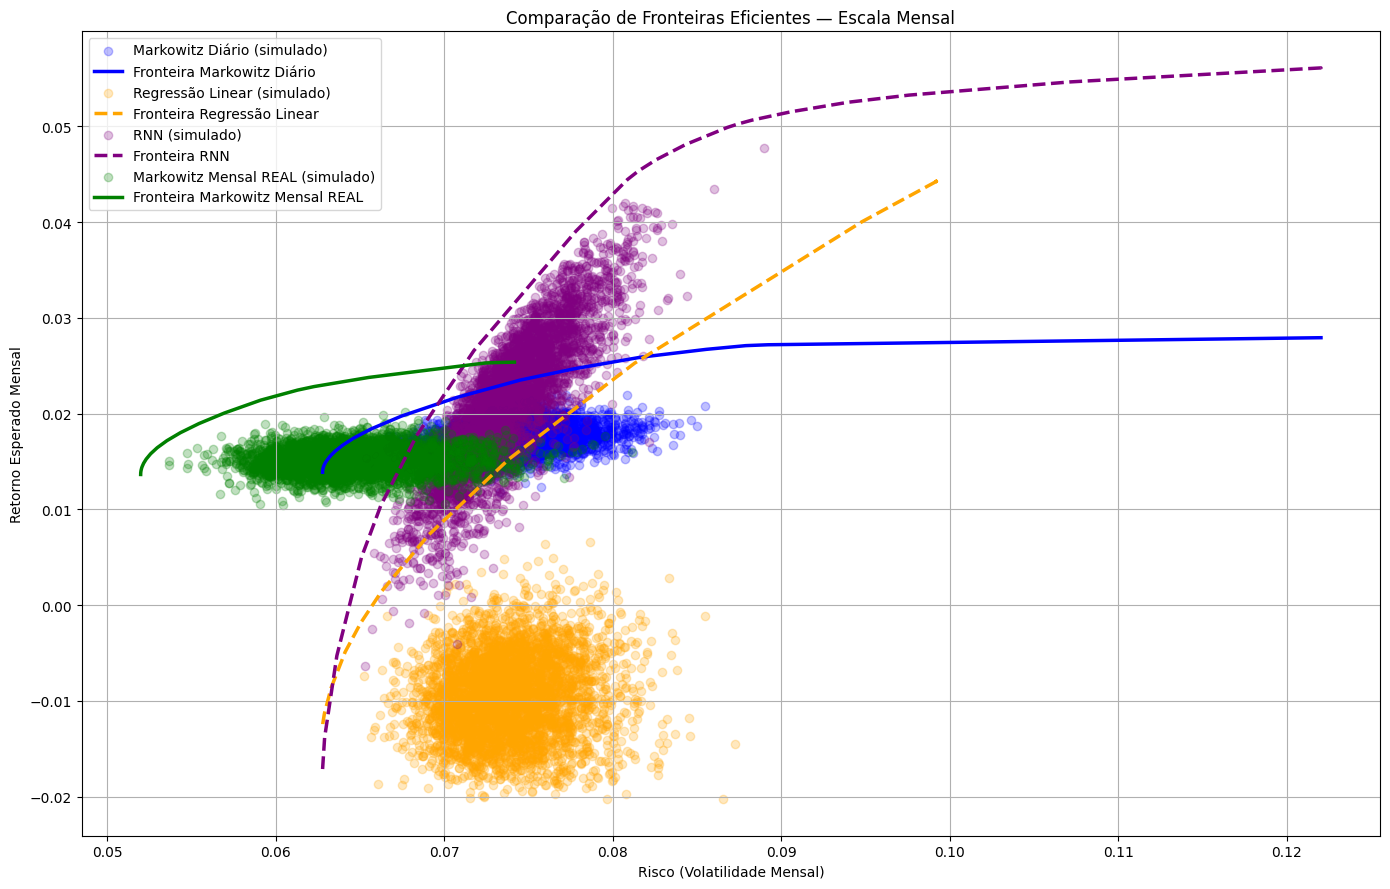

In [5]:
compare_frontiers(models)


0.22 Markowitz Diário 0.08011156182304538 0.025445198564154888
0.56 Regressão Linear 0.0794620904738375 0.02297218663246534
0.63 RNN 0.08015238764022019 0.04324779368816006
0.0 Markowitz Mensal REAL 0.07417206026802907 0.02537801160533151


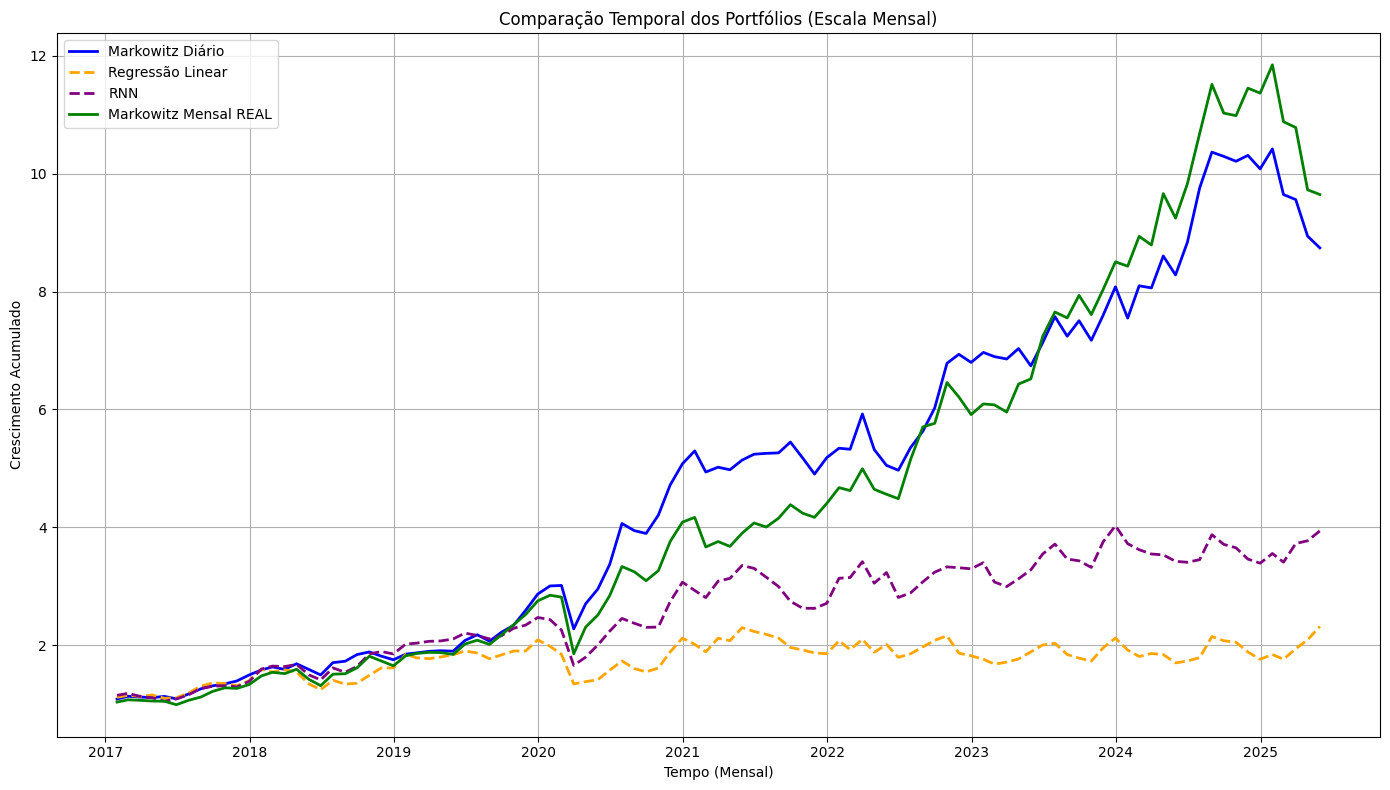

In [ ]:


compare_time_series(models, target_risk=0.08)


In [21]:
from outputs.charts.markowitz_plot import (
    find_lambda_for_risk,
    solve_markowitz,
    portfolio_volatility,
    portfolio_return
)

# from src.data.loader import load_prices, compute_returns
# from src.models.lr import predict_mean_returns
# from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
# from outputs.charts.models_markowitz import plot_LR_parity_return_prediction, plot_LR_parity_by_all_assets

def compare_time_series_local(
    models: list,
    target_risk=0.1
):
    """
    Compara o crescimento acumulado mensal de N modelos.

    Cada item de 'models':
    {
        "name": str,
        "mean_returns": pd.Series,
        "cov": pd.DataFrame,
        "color": str,
        "linestyle": str
    }
    """

    plt.figure(figsize=(14, 8))

    for model in models:

        name = model["name"]
        mean = model["mean_returns"]
        cov = model["cov"]
        is_monthly = model["is_monthly"]
        returns_daily = model["returns_daily"]
         # ------------ CONVERSÃO (diário → mensal) ------------
        if not is_monthly:
            dias = 21
            mean = (1 + mean) ** dias - 1
            cov = cov * dias

        lamb = find_lambda_for_risk(mean, cov, target_risk)

        weights = solve_markowitz(mean, cov, lamb=lamb)

        print(lamb, name, portfolio_volatility(weights, cov), portfolio_return(weights, mean))

        port_monthly = returns_daily.resample("ME").agg(lambda x: (1 + x).prod() - 1)
        port_monthly = port_monthly.dot(weights)

        print(port_monthly.mean(), mean.dot(weights))

        acum = (1 + port_monthly).cumprod()

        plt.plot(
            port_monthly.index, port_monthly,
            # acum.index, acum,
            label=name,
            linewidth=2,
            color=model["color"],
            linestyle=model["linestyle"]
        )

    plt.title("Comparação Temporal dos Portfólios (Escala Mensal)")
    plt.xlabel("Tempo (Mensal)")
    plt.ylabel("Crescimento Acumulado")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

0.22 Markowitz Diário 0.08011156182304538 0.025445198564154888
0.023709060070908387 0.025445198564154888
0.56 Regressão Linear 0.0794620904738375 0.02297218663246534
0.011275825463163854 0.02297218663246534
0.63 RNN 0.08015238764022019 0.04324779368816006
0.016150667908783917 0.04324779368816006
0.0 Markowitz Mensal REAL 0.07417206026802907 0.02537801160533151
0.025505921274951854 0.02537801160533151


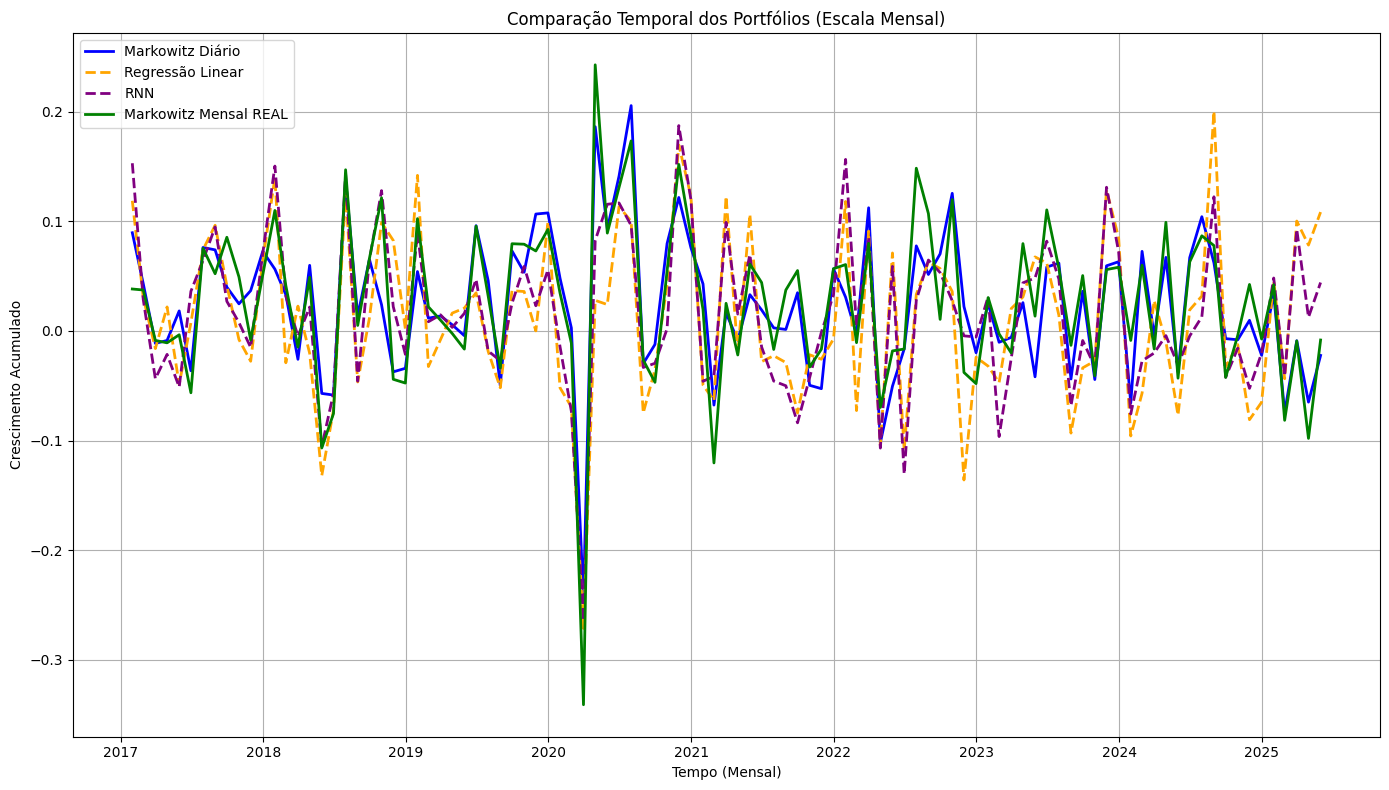

In [26]:
compare_time_series_local(models, target_risk=0.08)


,Model,Mean,Volatility,Sharpe,Cumulative_Return
0,standard_markowitz,0.000687,0.013731,0.793843,2.448597
0,linear_metrics,0.000670,0.013996,0.759467,2.302013
0,rnn_metrics,0.000781,0.014041,0.882484,3.159481


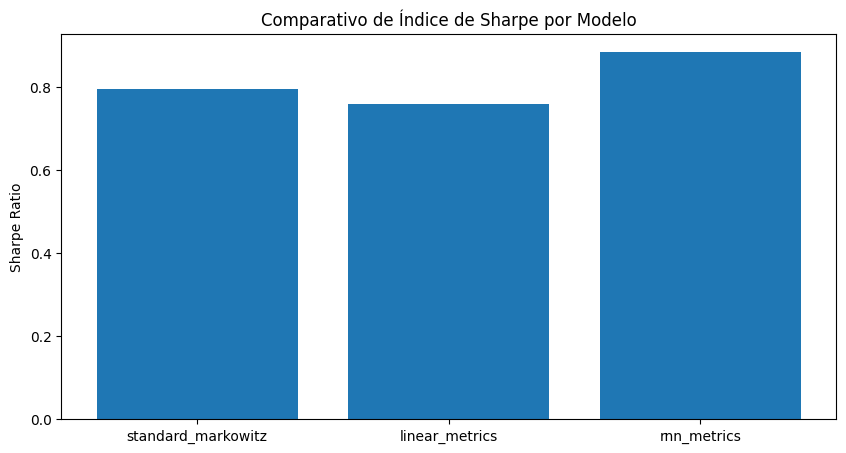

In [7]:
files = [
    "../outputs/models/standard_markowitz.csv",
    "../outputs/models/linear_metrics.csv",
    "../outputs/models/rnn_metrics.csv",
]

df_results = pd.concat([pd.read_csv(f) for f in files])
display(df_results)

plt.figure(figsize=(10, 5))
plt.bar(df_results["Model"], df_results["Sharpe"])
plt.title("Comparativo de Índice de Sharpe por Modelo")
plt.ylabel("Sharpe Ratio")
plt.show()


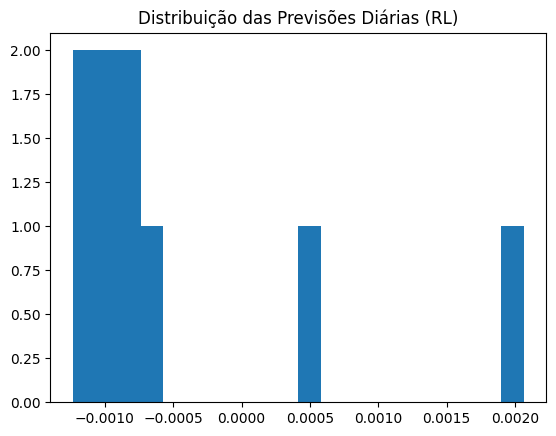

In [8]:
plt.hist(pred_daily, bins=20)
plt.title("Distribuição das Previsões Diárias (RL)")
plt.show()


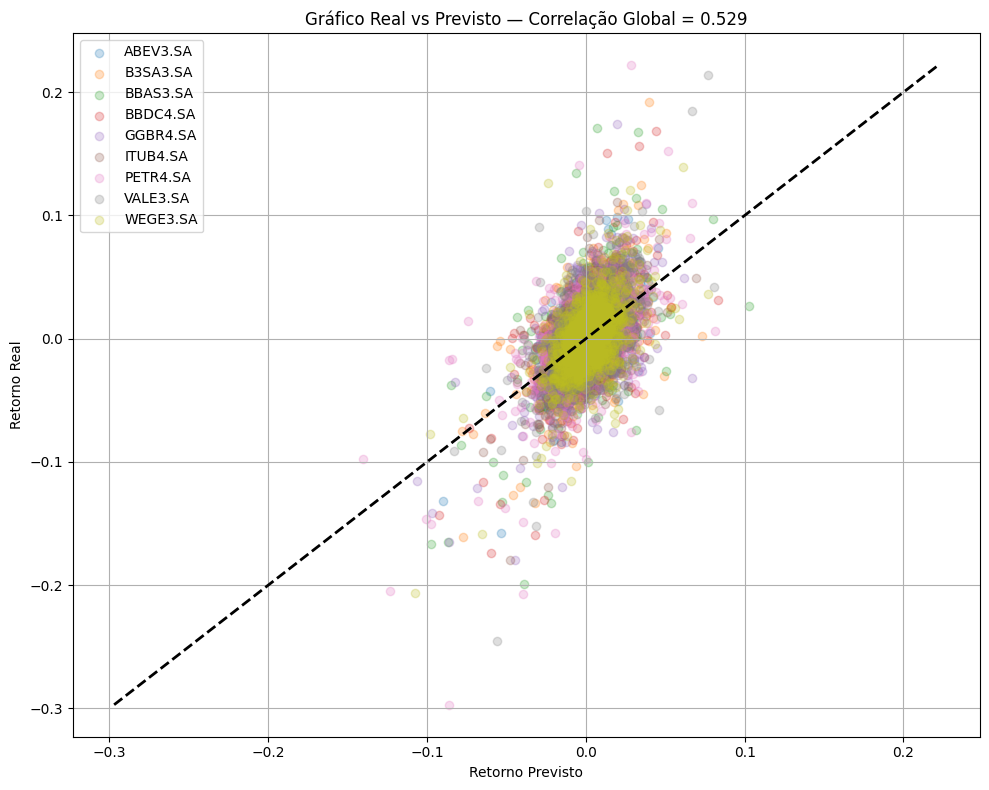

In [9]:
plot_LR_parity_return_prediction(prices, window=5)

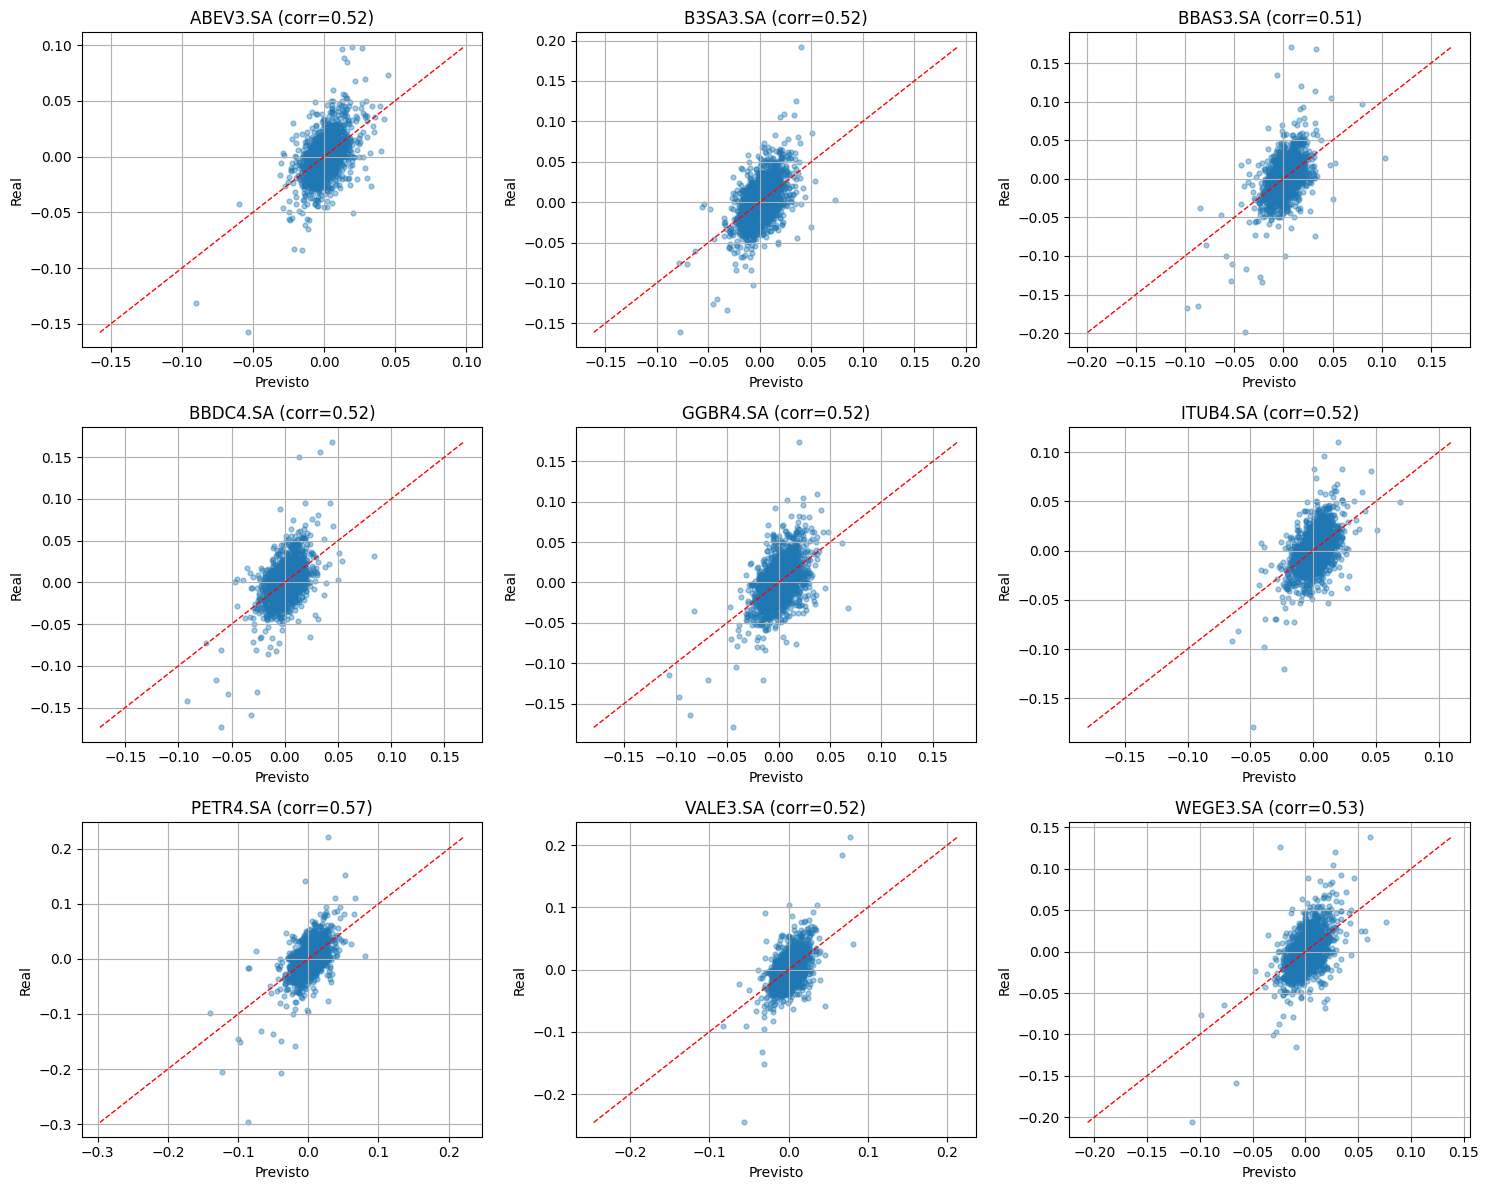

In [10]:
plot_LR_parity_by_all_assets(prices, window=5)